In [1]:
require(ggplot2)
#TODO compare stacking vs stacking no features vs best single model
## Gives count, mean, standard deviation, standard error of the mean, and confidence interval (default 95%).
##   data: a data frame.
##   measurevar: the name of a column that contains the variable to be summariezed
##   groupvars: a vector containing names of columns that contain grouping variables
##   na.rm: a boolean that indicates whether to ignore NA's
##   conf.interval: the percent range of the confidence interval (default is 95%)
summarySE <- function(data=NULL, measurevar, groupvars=NULL, na.rm=FALSE,
                      conf.interval=.95, .drop=TRUE) {
    library(plyr)

    # New version of length which can handle NA's: if na.rm==T, don't count them
    length2 <- function (x, na.rm=FALSE) {
        if (na.rm) sum(!is.na(x))
        else       length(x)
    }

    # This does the summary. For each group's data frame, return a vector with
    # N, mean, and sd
    datac <- ddply(data, groupvars, .drop=.drop,
      .fun = function(xx, col) {
        c(N    = length2(xx[[col]], na.rm=na.rm),
          mean = mean   (xx[[col]], na.rm=na.rm),
          sd   = sd     (xx[[col]], na.rm=na.rm)
        )
      },
      measurevar
    )

    # Rename the "mean" column    
    datac <- rename(datac, c("mean" = measurevar))

    datac$se <- datac$sd / sqrt(datac$N)  # Calculate standard error of the mean

    # Confidence interval multiplier for standard error
    # Calculate t-statistic for confidence interval: 
    # e.g., if conf.interval is .95, use .975 (above/below), and use df=N-1
    ciMult <- qt(conf.interval/2 + .5, datac$N-1)
    datac$ci <- datac$se * ciMult

    return(datac)
}

Loading required package: ggplot2


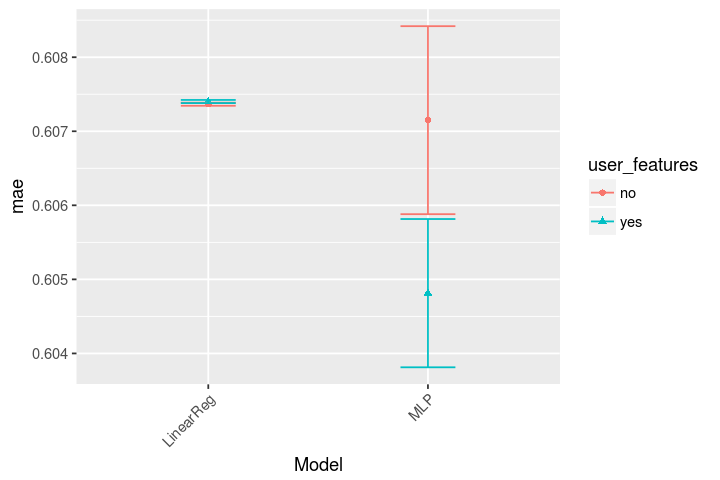

In [2]:
options(repr.plot.width=6, repr.plot.height=4)

df2 = read.csv("/home/guz/personal/msc-gustavo-penha/data/created/weighted_no_features_approach_results.csv")
df1 = read.csv("/home/guz/personal/msc-gustavo-penha/data/created/weighted_approach_results.csv")
df1["user_features"] = "yes"
df2["user_features"] = "no"
df_join <- rbind(df1, df2)

tgc <- data.frame(summarySE(df_join, measurevar="mae",groupvars = c("Model","user_features")))

ggplot(tgc, aes(Model,mae)) + 
    geom_point(aes(color=user_features,shape=user_features))+
    geom_errorbar(width=.25, aes(ymin=mae-ci, ymax=mae+ci,color=user_features)) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [ ]:
# TODO compare with best single model

best_df = read.csv("/home/guz/personal/msc-gustavo-penha/data/created_17/predictions_BiasedMatrixFactorization_with_errors.csv")
best_df[0:10,]

In [ ]:
rmse <- function(error)
{
    sqrt(mean(error^2))
}
print(rmse(best_df["error_BiasedMatrixFactorization"]))
nrow(best_df)

In [11]:
preds = read.csv("/home/guz/personal/msc-gustavo-penha/data/created/weighted_predictions.csv")
preds_df = merge(best_df,preds,by=c("movieId","userId"))
names(preds_df)[names(preds_df) == 'predictions'] <- 'prediction_weighted'
preds_df["error_weighted"] = abs(preds_df["prediction_weighted"] - preds_df["rating"])
preds_df[0:10,]

movieId,userId,prediction_BiasedMatrixFactorization,rating,timestamp,error_BiasedMatrixFactorization,prediction_weighted,error_weighted
100008,27053,2.639630,3.0,1358922494,0.360370,2.798114,0.20188645
100008,51558,3.071274,3.0,1422833166,0.071274,3.098759,0.09875883
100010,106476,3.130507,2.5,1420774929,0.630507,3.410486,0.91048633
100010,12131,1.942971,1.5,1398369060,0.442971,2.214252,0.71425193
100010,127063,2.259258,3.0,1416758994,0.740742,2.405834,0.59416551
1000,101282,2.246842,1.5,1053916995,0.746842,2.357926,0.85792590
100010,135806,2.306104,3.0,1375739179,0.693896,2.803516,0.19648367
100010,20180,2.623380,1.0,1424294683,1.623380,2.735552,1.73555242
100010,24994,3.509788,4.0,1424470787,0.490212,3.803418,0.19658213
1000,102636,3.552857,3.0,968637191,0.552857,3.256425,0.25642532


In [12]:
nrow(preds_df)

[1] 7915194

In [13]:
# preds = read.csv("/home/guz/personal/msc-gustavo-penha/data/created/weighted_predictions_no_features.csv")
# preds_df = merge(preds_df,preds,by=c("movieId","userId"))
# names(preds_df)[names(preds_df) == 'predictions'] <- 'prediction_weighted_no_features'
# preds_df["error_weighted_no_features"] = abs(preds_df["prediction_weighted_no_features"] - preds_df["rating"])
# preds_df[0:10,]

In [14]:
tgc1 <- summarySE(preds_df, measurevar="error_BiasedMatrixFactorization")
tgc2 <- summarySE(preds_df, measurevar="error_weighted")
tgc3 <- summarySE(preds_df, measurevar="error_weighted_no_features")

# mean(preds_df[["error_weighted_no_features"]])
comparison= data.frame(mae = c(mean(preds_df[["error_weighted"]]),mean(preds_df[["error_BiasedMatrixFactorization"]]),mean(preds_df[["error_weighted_no_features"]])),model = c("weighted","best_single","weighted_no_features"),
                       ci = c(tgc2$ci,tgc1$ci,tgc3$ci))
comparison

Warning message in mean.default(xx[[col]], na.rm = na.rm):
“argument is not numeric or logical: returning NA”Warning message in qt(conf.interval/2 + 0.5, datac$N - 1):
“NaNs produzidos”Warning message in mean.default(preds_df[["error_weighted_no_features"]]):
“argument is not numeric or logical: returning NA”

mae,model,ci
0.6067210,weighted,0.0003657561
0.6055113,best_single,0.0003575731
NA,weighted_no_features,NA


Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

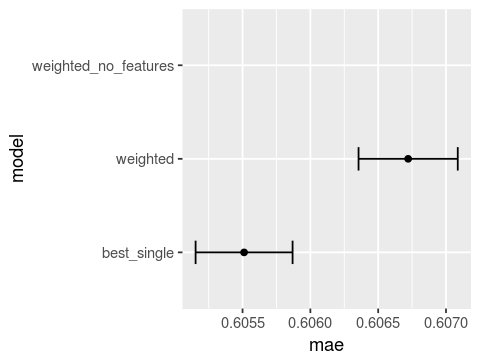

In [15]:
require(ggplot2)
options(repr.plot.width=4, repr.plot.height=3)
ggplot(comparison, aes(x=model,y=mae)) + geom_point()+
geom_errorbar(position=position_dodge(.9), width=.25, aes(ymin=mae-ci, ymax=mae+ci)) + 
 coord_flip()

In [18]:
mae_df = read.csv("/home/guz/personal/msc-gustavo-penha/data/created/weighted_approach_results.csv")
pvalues = pairwise.t.test(mae_df$mae, mae_df$Model, p.adjust = "none")$p.value
pvalues = format(pvalues, digits=2) 
pvalues

,LinearReg
MLP,1.5e-05


Loading required package: ggplot2


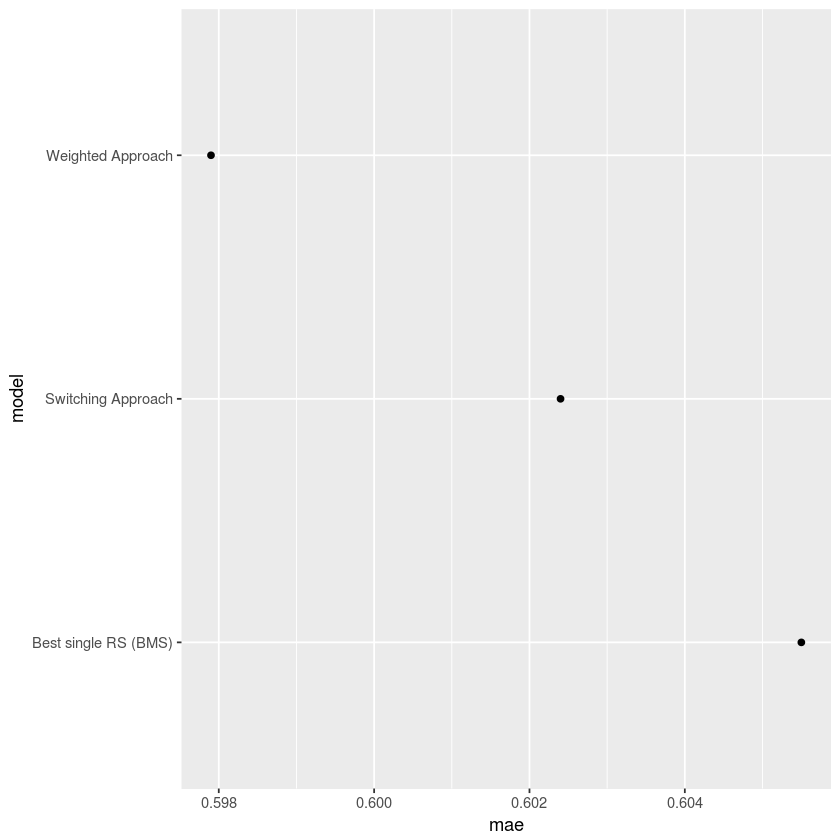

In [1]:
require(ggplot2)
comparison = data.frame(mae = c(0.5979,0.6024,0.6055),model = c("Weighted Approach","Switching Approach","Best single RS (BMS)"))
ggplot(comparison, aes(x=model,y=mae)) + geom_point()+
 coord_flip()